In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Classical ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Advanced Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
train_df = pd.read_parquet("celebal-ana-verse-h/train.parquet", engine='pyarrow')
test_df = pd.read_parquet("celebal-ana-verse-h/test.parquet", engine='pyarrow')
sample_submission = pd.read_parquet("celebal-ana-verse-h/sample_submission.parquet", engine='pyarrow')


# Basic overview
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

# Preview first few rows
train_df.head()

Train Shape: (1639424, 7)
Test Shape: (409856, 7)


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


Index(['Date', 'X1', 'X2', 'X3', 'X4', 'X5', 'target'], dtype='object')


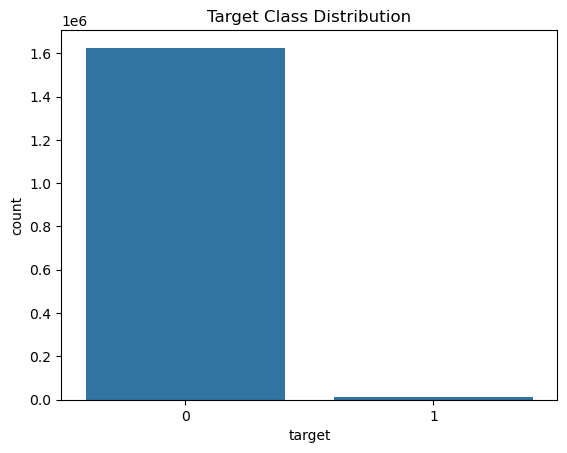

In [4]:
# List column names
print(train_df.columns)

# Replace 'target' with your actual target column name from this output
target_column = 'target'  # <<< CHANGE THIS IF NEEDED

# Check for class balance
sns.countplot(x=train_df[target_column])
plt.title("Target Class Distribution")
plt.show()

In [5]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Separate features and target
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

# Select only numeric columns (exclude datetime, object, etc.)
X_numeric = X.select_dtypes(include=['number'])

# Now apply imputation ONLY on numeric columns
imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

# (Optional) Keep the non-numeric columns (if you need them later)
non_numeric = X.drop(columns=X_numeric.columns)

# Combine back the cleaned numeric and untouched non-numeric columns
X_cleaned = pd.concat([X_numeric_imputed, non_numeric.reset_index(drop=True)], axis=1)


In [6]:
print(X.dtypes)


Date    datetime64[ns]
X1             float64
X2             float64
X3             float64
X4             float64
X5             float64
dtype: object


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_numeric = pd.DataFrame(scaler.fit_transform(X_numeric_imputed), columns=X_numeric_imputed.columns)


In [8]:
# Assuming you're only working with numeric columns
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

# Select numeric columns
X_numeric = X.select_dtypes(include=['number'])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

# Scale the numeric data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric_imputed), columns=X_numeric_imputed.columns)

# Now do the train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [9]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(n_estimators=50),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50),
    'LightGBM': LGBMClassifier(n_estimators=50),
    'CatBoost': CatBoostClassifier(verbose=0, iterations=50)
}

X_train_small = X_train.sample(frac=0.2, random_state=42)
y_train_small = y_train.loc[X_train_small.index].astype(int)
y_val = y_val.astype(int)

for name, model in models.items():
    model.fit(X_train_small, y_train_small)
    preds = model.predict(X_val)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_val, preds))
    print("F1 Score:", f1_score(y_val, preds, average='weighted'))
    print(classification_report(y_val, preds))




Logistic Regression Results:
Accuracy: 0.991631212162801
F1 Score: 0.9884422139316486
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    325118
           1       0.53      0.07      0.12      2767

    accuracy                           0.99    327885
   macro avg       0.76      0.53      0.56    327885
weighted avg       0.99      0.99      0.99    327885


Decision Tree Results:
Accuracy: 0.9880506885035912
F1 Score: 0.9879791794294354
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    325118
           1       0.29      0.28      0.28      2767

    accuracy                           0.99    327885
   macro avg       0.64      0.64      0.64    327885
weighted avg       0.99      0.99      0.99    327885


KNN Results:
Accuracy: 0.9911401863458225
F1 Score: 0.988922777967813
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    3251

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:26:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
Accuracy: 0.9930951400643518
F1 Score: 0.9910839624470623
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    325118
           1       0.85      0.22      0.35      2767

    accuracy                           0.99    327885
   macro avg       0.92      0.61      0.67    327885
weighted avg       0.99      0.99      0.99    327885

[LightGBM] [Info] Number of positive: 2182, number of negative: 260126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 262308, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008318 -> initscore=-4.780924
[LightGBM] [Info] Start training from score -4.780924

LightGBM Results:
Accuracy: 0.9934946703874834
F1 Score: 0.9922761085182971
              precision    

In [10]:
from sklearn.model_selection import RandomizedSearchCV

X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train.loc[X_sample.index]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=4,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_sample, y_sample)
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 100, 'max_depth': 10}


In [18]:
# Step 1: Drop unnecessary columns from test_df
test_features = test_df.drop(columns=['Date', 'ID'])

# Step 2: Impute missing values using the same imputer used on training data
test_imputed = imputer.transform(test_features)

# Step 3: Scale the data using the same scaler used on training data
test_scaled = scaler.transform(pd.DataFrame(test_imputed, columns=X_train.columns))

# Step 4: Predict using the best model from RandomizedSearchCV
final_model = random_search.best_estimator_
test_preds = final_model.predict(test_scaled)

# Step 5: Ensure test_preds matches submission length
if len(test_preds) != len(sample_submission):
    print(f"Length mismatch! Predictions: {len(test_preds)}, Submission: {len(sample_submission)}")
else:
    # Step 6: Assign predictions to submission DataFrame
    submission = sample_submission.copy()
    submission[target_column] = test_preds

    # Step 7: Save to CSV
    submission.to_csv("final_submission.csv", index=False)
    print("✅ Submission file saved as final_submission.csv")


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Length mismatch! Predictions: 409856, Submission: 50


In [21]:
print("test_df shape:", test_df.shape)
print("sample_submission shape:", sample_submission.shape)
test_df = pd.read_parquet("celebal-ana-verse-h/test.parquet")  # Replace with your actual file


test_df shape: (409856, 7)
sample_submission shape: (50, 2)


In [28]:
print("Test shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)
print("Sample submission head:\n", sample_submission.head())


Test shape: (409856, 7)
Sample submission shape: (50, 2)
Sample submission head:
        ID target
0  409856      0
1  409857      0
2  409858      0
3  409859      0
4  409860      0


In [30]:
import pandas as pd

# Load test data
test_df = pd.read_parquet("celebal-ana-verse-h/test.parquet")

# Create a new submission DataFrame with matching IDs
correct_submission = pd.DataFrame({
    'ID': test_df['ID'],
    'target': test_preds  # Your predicted values
})

# Save the correct submission
correct_submission.to_csv("final_submission.csv", index=False)
print("✅ Correct submission file saved as final_submission.csv")


✅ Correct submission file saved as final_submission.csv


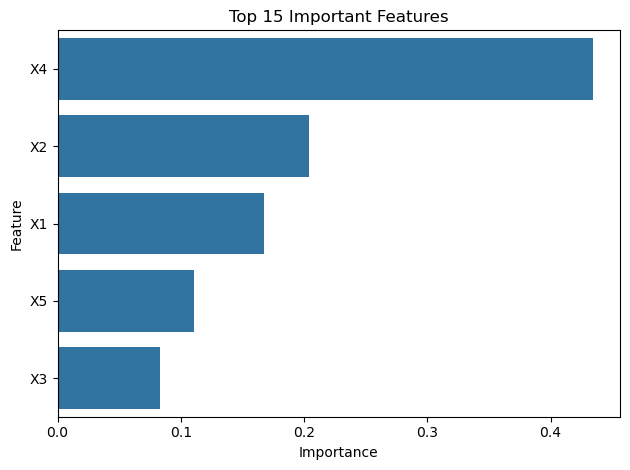

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances and correct feature names
importances = final_model.feature_importances_
feat_names = X_train.columns  # Use this instead of train_df

# Create DataFrame and plot
feat_imp_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
})

# Sort and plot top 15
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Drop or convert datetime columns before splitting
X = train_df.drop(columns=[target_column])

# Convert datetime columns if any
datetime_cols = X.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    X[col + '_hour'] = X[col].dt.hour
    X[col + '_day'] = X[col].dt.day
    X[col + '_month'] = X[col].dt.month
    X = X.drop(columns=[col])

# Target column
y = train_df[target_column].astype(int)  # ✅ Convert to int

# Train/Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
final_model.fit(X_train, y_train)

# Predictions on validation set
y_pred = final_model.predict(X_valid).astype(int)  # ✅ Ensure predictions are int

# Evaluation
print("✅ Best Model Evaluation Metrics:")
print(f"📊 Accuracy Score: {accuracy_score(y_valid, y_pred):.4f}")
print(f"🎯 F1 Score: {f1_score(y_valid, y_pred):.4f}")


✅ Best Model Evaluation Metrics:
📊 Accuracy Score: 0.9950
🎯 F1 Score: 0.5964
